<a href="https://colab.research.google.com/github/nerudesu/anitag/blob/master/AniTag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required Libs

In [1]:
from google.colab import files
import torch
from torchvision import transforms
from PIL import Image
import json
import urllib, urllib.request
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np

# Load the model

In [2]:
model = torch.hub.load('RF5/danbooru-pretrained', 'resnet50')
model.eval()

Using cache found in /root/.cache/torch/hub/RF5_danbooru-pretrained_master


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [3]:
# Get class names
with urllib.request.urlopen("https://github.com/RF5/danbooru-pretrained/raw/master/config/class_names_6000.json") as url:
    class_names = json.loads(url.read().decode())

Preprocessing code

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(360),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7137, 0.6628, 0.6519], std=[0.2970, 0.3017, 0.2979]),
])

In [5]:
def process_image(input_image):
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # Use CUDA whenever available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)

  # The output has unnormalized scores. To get probabilities, you can run a sigmoid on it.
  probs = torch.sigmoid(output[0]) # Tensor of shape 6000, with confidence scores over Danbooru's top 6000 tags
  return probs

In [6]:
def recognize_image(input_image):
  d = {}

  probs = process_image(input_image)
  filtered_probs = probs[probs > 0.2]

  inds = probs.argsort(descending=True)

  for i in inds[0:len(filtered_probs)]:
    d[class_names[i]] = round(probs[i].cpu().numpy().item(),4)

  mask = np.array(input_image)
  image_colors = ImageColorGenerator(mask)

  wordcloud = WordCloud(background_color="white", mode="RGBA", mask=mask)
  wordcloud.generate_from_frequencies(frequencies=d)

  f, axarr = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(14,14))

  # remove the x and y ticks
  for ax in axarr:
      ax.set_xticks([])
      ax.set_yticks([])

  axarr[0].set_title('Input image')
  axarr[0].imshow(input_image)
  axarr[1].set_title('Predictions')
  axarr[1].imshow(wordcloud.recolor(color_func=image_colors),
                  interpolation="bilinear")

# Image Recognition

In [7]:
def upload_image():
  uploaded = files.upload()

  for fn in uploaded.keys():
    # predicting images
    path = fn
    input_image = Image.open(path)
    recognize_image(input_image)

Saving Love_Live!_promotional_image.jpg to Love_Live!_promotional_image.jpg


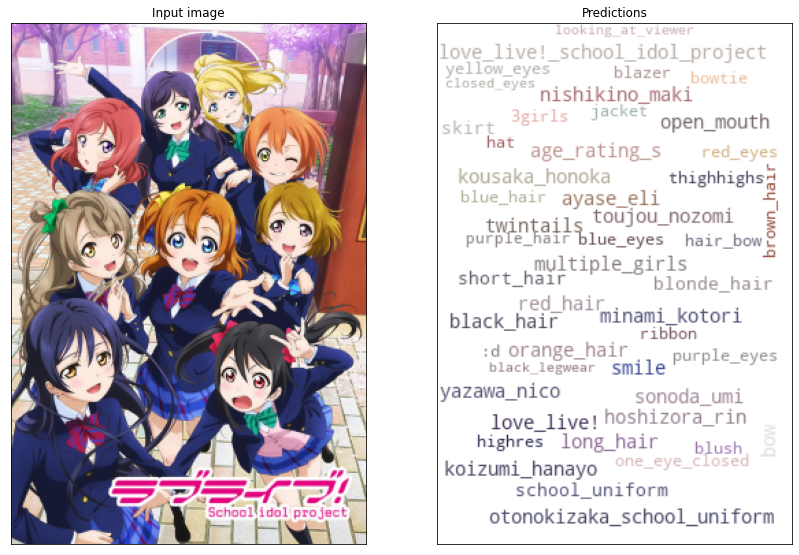

In [8]:
upload_image() # By Source, Fair use, https://en.wikipedia.org/w/index.php?curid=38075197

Saving Racingmiku2016.jpg to Racingmiku2016.jpg


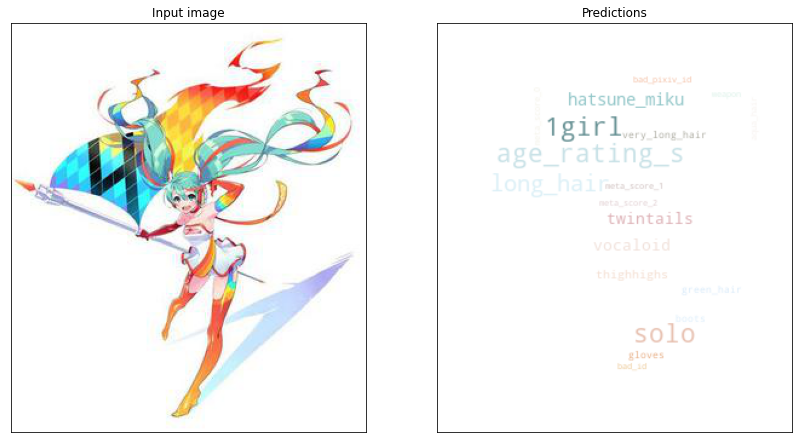

In [9]:
upload_image() # By Source (WP:NFCC#4), Fair use, https://en.wikipedia.org/w/index.php?curid=49668753

Now, try it with your own picture